In [1]:
import os
import shutil
from glob import glob
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from skimage.filters import roberts, sobel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [2]:
# Directories for Normal, Benign, and Malignant images
normal_dir = '/kaggle/input/new-columbia-breast-cancer/Columbia uni breast cancer dataset/Right Side/Normal'
benign_dir = '/kaggle/input/new-columbia-breast-cancer/Columbia uni breast cancer dataset/Right Side/Benign'
malignant_dir = '/kaggle/input/new-columbia-breast-cancer/Columbia uni breast cancer dataset/Right Side/Malignant'

In [3]:
# Get list of image paths for Normal, Benign, and Malignant images
normal_image_paths = glob(os.path.join(normal_dir, '*.jpg'))
benign_image_paths = glob(os.path.join(benign_dir, '*.jpg'))
malignant_image_paths = glob(os.path.join(malignant_dir, '*.jpg'))


In [4]:
if not normal_image_paths:
    print("Error: No normal images found in the specified directory.")
else:
    print(f"Found {len(normal_image_paths)} normal images in the directory.")

if not benign_image_paths:
    print("Error: No benign images found in the specified directory.")
else:
    print(f"Found {len(benign_image_paths)} benign images in the directory.")

if not malignant_image_paths:
    print("Error: No malignant images found in the specified directory.")
else:
    print(f"Found {len(malignant_image_paths)} malignant images in the directory.")


Found 63 normal images in the directory.
Found 37 benign images in the directory.
Found 21 malignant images in the directory.


In [5]:
# Combine Normal, Benign, and Malignant image paths
all_image_paths = normal_image_paths + benign_image_paths + malignant_image_paths

# Create labels (0 for Normal, 1 for Benign, 2 for Malignant)
labels = [0] * len(normal_image_paths) + [1] * len(benign_image_paths) + [2] * len(malignant_image_paths)


In [6]:
# Function to apply masks and save images
def apply_masks_and_save(image_paths, dest_dir):
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
        edge_roberts = roberts(img)
        edge_sobel = sobel(img)
        
        # Stack the original, roberts, and sobel images
        stacked_image = np.stack((img, edge_roberts, edge_sobel), axis=-1)
        
        # Create the destination path
        file_name = os.path.basename(img_path)
        dest_path = os.path.join(dest_dir, file_name)
        
        # Save the stacked image
        cv2.imwrite(dest_path, (stacked_image * 255).astype(np.uint8))


In [7]:
# Apply masks and save images in new directories
masked_normal_dir = 'masked_images/Normal'
masked_benign_dir = 'masked_images/Benign'
masked_malignant_dir = 'masked_images/Malignant'

In [8]:
os.makedirs(masked_normal_dir, exist_ok=True)
os.makedirs(masked_benign_dir, exist_ok=True)
os.makedirs(masked_malignant_dir, exist_ok=True)

apply_masks_and_save(normal_image_paths, masked_normal_dir)
apply_masks_and_save(benign_image_paths, masked_benign_dir)
apply_masks_and_save(malignant_image_paths, masked_malignant_dir)

# Get new image paths after applying masks
masked_normal_image_paths = glob(os.path.join(masked_normal_dir, '*.jpg'))
masked_benign_image_paths = glob(os.path.join(masked_benign_dir, '*.jpg'))
masked_malignant_image_paths = glob(os.path.join(masked_malignant_dir, '*.jpg'))


In [9]:
# Combine Normal, Benign, and Malignant image paths again
all_image_paths = masked_normal_image_paths + masked_benign_image_paths + masked_malignant_image_paths

# Split the data into 80% training and 20% validation
train_paths, val_paths, train_labels, val_labels = train_test_split(all_image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# Since the testing set is supposed to include all images, use the original list of all image paths
test_paths = all_image_paths
test_labels = labels

# Directories for training, validation, and testing datasets
train_dir = 'dataset_split/train'
val_dir = 'dataset_split/val'
test_dir = 'dataset_split/test'


In [10]:
# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [11]:
# Function to copy images to their respective directories
def copy_images(image_paths, labels, dest_dir):
    for img_path, label in zip(image_paths, labels):
        label_dir = os.path.join(dest_dir, 'Normal' if label == 0 else 'Benign' if label == 1 else 'Malignant')
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)

# Copy images to training, validation, and testing directories
copy_images(train_paths, train_labels, train_dir)
copy_images(val_paths, val_labels, val_dir)
copy_images(test_paths, test_labels, test_dir)

In [12]:
print(f'Number of training images: {len(train_paths)}')
print(f'Number of validation images: {len(val_paths)}')
print(f'Number of testing images: {len(test_paths)}')


Number of training images: 96
Number of validation images: 25
Number of testing images: 121


In [13]:
# Image transformations with data augmentation
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [14]:
# Create datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=transform['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=transform['test'])

# Print the number of images for training, validation, and testing
print(f'Number of training images: {len(train_dataset)}')
print(f'Number of validation images: {len(val_dataset)}')
print(f'Number of testing images: {len(test_dataset)}')


Number of training images: 96
Number of validation images: 25
Number of testing images: 121


In [15]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Definition
model_densenet = models.densenet121(pretrained=True)
num_features = model_densenet.classifier.in_features
model_densenet.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout for regularization
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout for regularization
    nn.Linear(256, 3),  # Change to 3 output classes
)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 109MB/s]


In [16]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_densenet = model_densenet.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_densenet.parameters(), lr=0.0001, weight_decay=0.01)  # Add weight decay for L2 regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [17]:
# Function to train and validate the model
def train_and_validate(model, criterion, optimizer, train_loader, val_loader, num_epochs=15):
    for epoch in range(num_epochs):
        print(f'Starting epoch {epoch+1}/{num_epochs}')

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            if i % 100 == 0:
                print(f'Training batch {i}/{len(train_loader)}')
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):
                if i % 100 == 0:
                    print(f'Validation batch {i}/{len(val_loader)}')
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = correct / total

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
        scheduler.step()

In [18]:
# Train and validate the model
train_and_validate(model_densenet, criterion, optimizer, train_loader, val_loader, num_epochs=15)

Starting epoch 1/15
Training batch 0/3
Validation batch 0/1
Epoch 1/15, Train Loss: 1.1064, Train Accuracy: 0.3021, Validation Loss: 1.0900, Validation Accuracy: 0.4400
Starting epoch 2/15
Training batch 0/3
Validation batch 0/1
Epoch 2/15, Train Loss: 1.0637, Train Accuracy: 0.4375, Validation Loss: 1.0563, Validation Accuracy: 0.5200
Starting epoch 3/15
Training batch 0/3
Validation batch 0/1
Epoch 3/15, Train Loss: 1.0513, Train Accuracy: 0.4792, Validation Loss: 1.0250, Validation Accuracy: 0.5200
Starting epoch 4/15
Training batch 0/3
Validation batch 0/1
Epoch 4/15, Train Loss: 1.0075, Train Accuracy: 0.5208, Validation Loss: 1.0040, Validation Accuracy: 0.5200
Starting epoch 5/15
Training batch 0/3
Validation batch 0/1
Epoch 5/15, Train Loss: 1.0001, Train Accuracy: 0.5208, Validation Loss: 0.9978, Validation Accuracy: 0.5200
Starting epoch 6/15
Training batch 0/3
Validation batch 0/1
Epoch 6/15, Train Loss: 1.0119, Train Accuracy: 0.5208, Validation Loss: 0.9958, Validation Acc

In [19]:
def show_predictions(images, labels, predictions, num_images=10):
    plt.figure(figsize=(20, 10))
    for idx in range(num_images):
        plt.subplot(2, num_images//2, idx+1)
        image = images[idx].transpose((1, 2, 0))  # Reorder dimensions for plotting
        image = (image * 255).astype(np.uint8)
        plt.imshow(image)
        true_label = ['Normal', 'Benign', 'Malignant'][labels[idx]]
        pred_label = ['Normal', 'Benign', 'Malignant'][predictions[idx]]
        plt.title(f'True: {true_label}\nPred: {pred_label}')
        plt.axis('off')
    plt.show()

In [20]:
def test_model(model, test_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_images = []  # To store images for visualization
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            if i % 100 == 0:
                print(f'Testing batch {i}/{len(test_loader)}')
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_images.extend(inputs.cpu().numpy())  # Store images

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Benign', 'Malignant'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Classification report
    print(classification_report(all_labels, all_predictions, target_names=['Normal', 'Benign', 'Malignant']))

    # Show predictions
    show_predictions(all_images, all_labels, all_predictions)


Testing batch 0/4
Test Loss: 0.9817, Test Accuracy: 0.5207


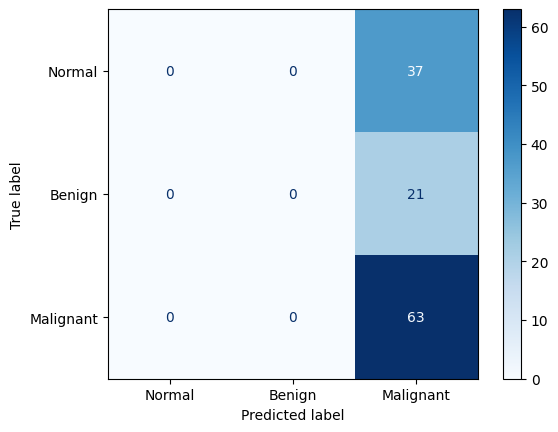

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        37
      Benign       0.00      0.00      0.00        21
   Malignant       0.52      1.00      0.68        63

    accuracy                           0.52       121
   macro avg       0.17      0.33      0.23       121
weighted avg       0.27      0.52      0.36       121



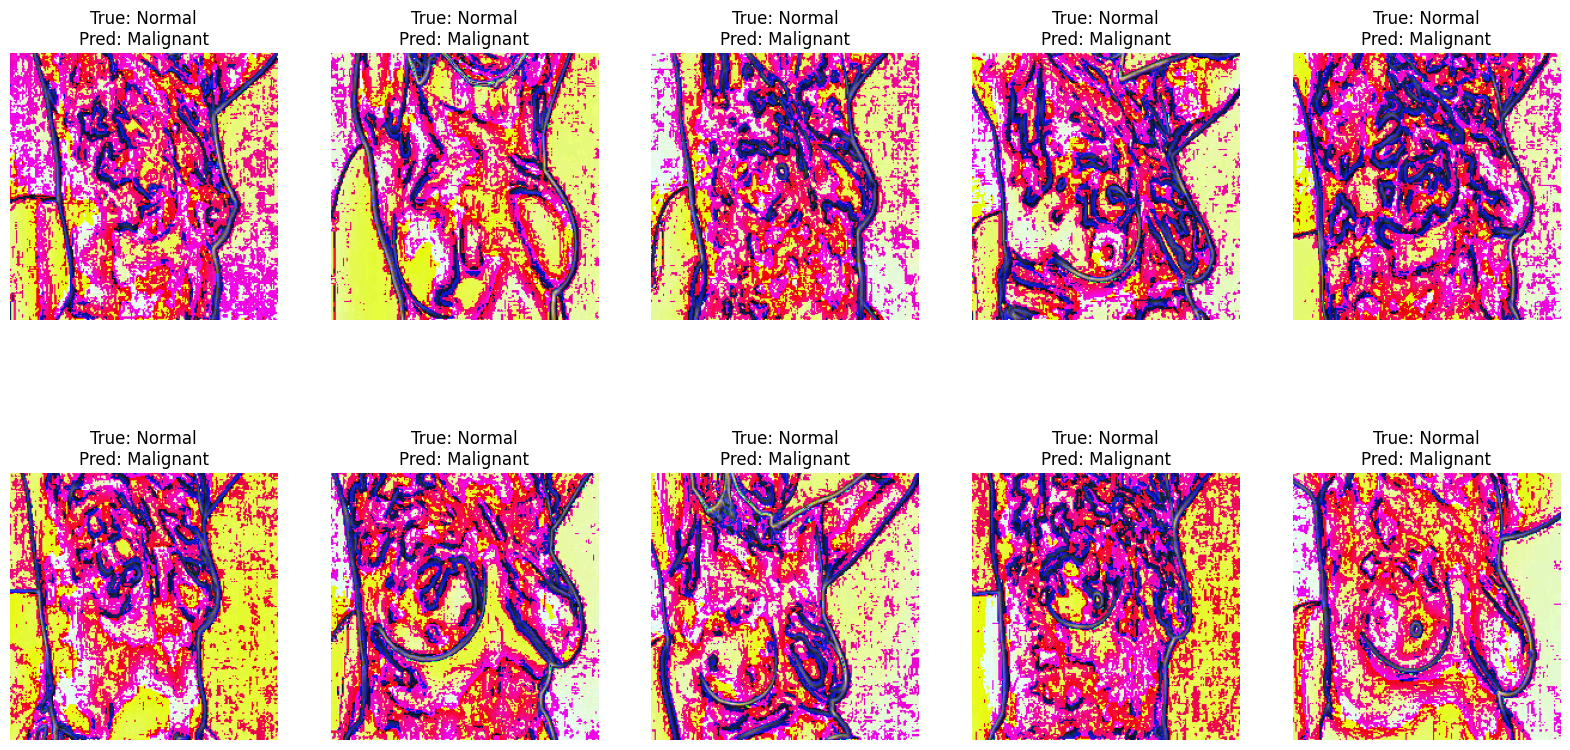

In [21]:
# Test the model
test_model(model_densenet, test_loader)
